In [29]:
%load_ext autoreload
%autoreload 2

import torch
from matplotlib import pyplot as plt
from text3d2video.attention_utils import (
    extended_attn_kv_hidden_states,
    single_frame_attn_kv_hidden_states,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms.functional as TF


def test_img(txt: str, resolution=100, font_percent=0.3, color="lightgray"):
    image_size = (resolution, resolution)
    gray_image = Image.new("RGB", image_size, color=color)  # RGB mode with mid-gray color

    # Draw the number on the image
    draw = ImageDraw.Draw(gray_image)
    font_size = resolution * font_percent
    font = ImageFont.truetype("arial.ttf", font_size)

    # Get bounding box of the text
    bbox = draw.textbbox((0, 0), txt, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    text_position = (
        (image_size[0] - text_width) / 2,
        (image_size[1] - text_height) / 2,
    )

    draw.text(
        text_position, txt, fill=(255, 255, 255), font=font
    )  # fill=(255, 255, 255) for white text

    # Convert the image to a PyTorch tensor
    return TF.to_tensor(gray_image)

In [35]:
from einops import rearrange

n_frames = 3
chunk_size = 2
resolution = 64

frames_cond = [test_img(str(i), resolution=resolution) for i in range(n_frames)]
frames_uncond = [test_img(str(i), resolution=resolution, color="black") for i in range(n_frames)]

chunked_images = torch.cat([torch.stack(frames_cond), torch.stack(frames_uncond)], dim=0)
x = rearrange(chunked_images, "b c h w -> b (h w) c")

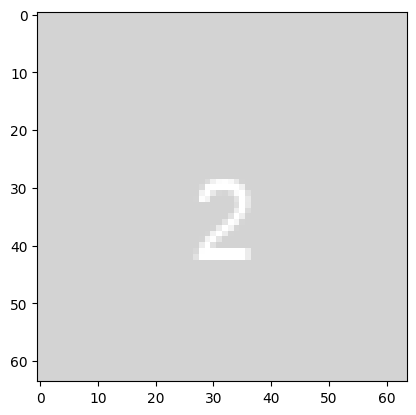

In [31]:
x_kv = single_frame_attn_kv_hidden_states(x, tgt_frame_index=2)

x_kv_square = rearrange(x_kv, "b (h w) d -> b d h w", h=resolution)

plt.imshow(x_kv_square[0].permute(1, 2, 0))

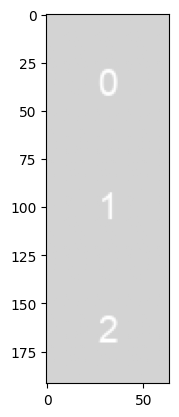

In [55]:
x_kv = extended_attn_kv_hidden_states(x)

x_kv_square = rearrange(x_kv, "b (h w) c -> b c h w", w=resolution)
plt.imshow(x_kv_square[0].permute(1, 2, 0))

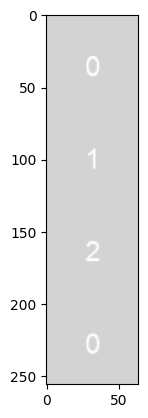

In [56]:
from text3d2video.attention_utils import extend_across_frame_dim


injected_kv = x_kv

injected_kv = extend_across_frame_dim(injected_kv, n_frames)
injected_kv = torch.cat([injected_kv, x], dim=1)

injected_kv.shape

x_kv_square = rearrange(injected_kv, "b (h w) c -> b c h w", w=resolution)

plt.imshow(x_kv_square[0].permute(1, 2, 0))

In [51]:
x_kv_square.shape

torch.Size([6, 3, 64, 256])